In [42]:
import requests
requests.packages.urllib3.disable_warnings() 
import json
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


###### Input your access_token here!######
access_token = 'xxxxxxxx'

# Import the time-series representing your historical demand - example CSV provided here:
infile = 'https://raw.githubusercontent.com/alvin-chan/bdt_django_front_end_postgres_mkdocs/master/example_data/bdt_example_input.csv'
# infile = 'https://github.com/bluedotthinking/wastenot-documentation/blob/master/example_data/bdt_example_input.csv'



input_df = pd.read_csv(infile, sep=',')

# Convert to a payload for WasteNot, adding in parameters for:
# - Shelf life of 2 days
# - Costs $1/unit, Revenue generated $5/unit sold
# - Optimise for maximum profit (revenue less cost)
# - Forecast 7 days ahead after the end of the historical time-series
# - A lot of stock on hand (3000 units, expiring in 2 days on 2018-08-12)

input_dict = {'timestamp':list(input_df['timestamp'].values),
              'demand':[int(x) for x in input_df['demand_units'].values],
              "cost": 1, "sale_price": 5, 
              "shelf_life_seconds": 432000., 
              "opt_param": "profit",
              "replenishment_dayofweek": [0,4],
              "forecast_periods_ahead":14,
              }

r = json.dumps(input_dict)
loaded_r = json.loads(r)

In [30]:
# Calling the WasteNot API service with the payload
url = "https://api.bluedotthinking.com/forecast"
payload=r

headers = {
    'Content-Type': 'application/json',
    'access_token': access_token
}

response = requests.request("POST", url, headers=headers, data=payload, verify=True)
print (response)

# Loading the response into JSON format
json_data = json.loads(response.text)

# Load the output payload into pandas dataframes, converting the timestamp columns into datetimes for easier plotting
delivery_df = pd.DataFrame(data={'timestamp':json_data['delivery_timestamp'],
                                 'delivered_units':json_data['delivery_units']
                                })
delivery_df['timestamp'] = pd.to_datetime(delivery_df['timestamp'])

forecast_df = pd.DataFrame(data={'timestamp': json_data['forecast_timestamp'],
                                 'predicted_demand_units': json_data['predicted_demand_units'],
                                 'optimised_demand_units': json_data['optimised_demand_units'],
                                })
input_df['timestamp'] = pd.to_datetime(input_df['timestamp'])



<Response [200]>


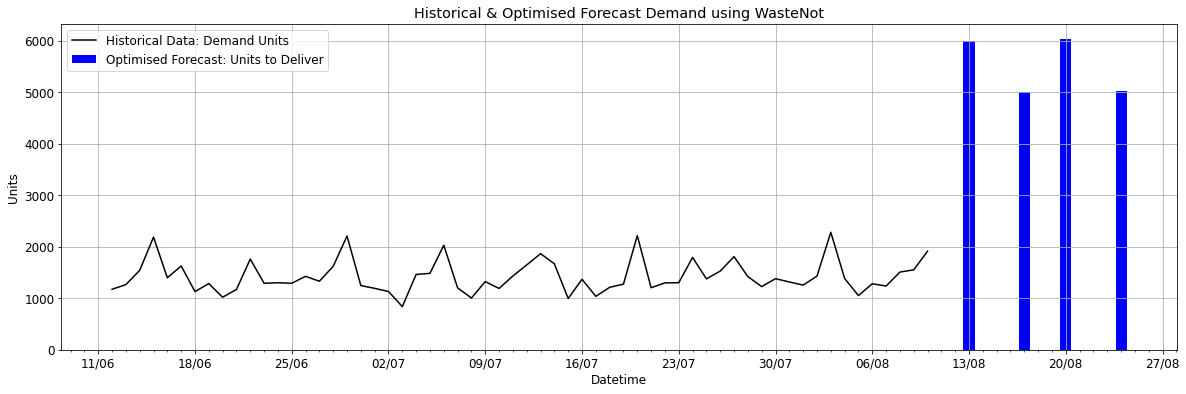

In [31]:
# Plotting:
# a) Historical demand for the last 60 days, 
# b) Units to be delivered using the optimised forecast over the next 7 days

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 6))

# Plot historical demand alongside the units to be delivered during forecast
ax.plot(input_df.timestamp[-60:], input_df.demand_units[-60:], color='black', linestyle='-', label='Historical Data: Demand Units')
ax.bar(delivery_df.timestamp, delivery_df.delivered_units, color='blue', 
       label='Optimised Forecast: Units to Deliver')

# For a less busy graph, only show the beginning of each week (Monday) as a major label
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_minor_locator(mdates.DayLocator())

ax.set_xlabel('Datetime')
ax.set_ylabel('Units')
ax.set_title('Historical & Optimised Forecast Demand using WasteNot')

ax.grid(True)
ax.legend(loc='upper left');

In [32]:
# Visualising the tables containing the delivered units (optimised), by day
delivery_df

,timestamp,delivered_units
0,2018-08-13,5992.0
1,2018-08-17,5001.0
2,2018-08-20,6026.0
3,2018-08-24,5025.0


In [33]:
# Visualising the tables containing the forecasted demand units (unoptimised and optimised), by day
forecast_df

,timestamp,predicted_demand_units,optimised_demand_units
0,2018-08-13,1397.0,1451.0
1,2018-08-14,1350.0,1402.0
2,2018-08-15,1448.0,1504.0
3,2018-08-16,1574.0,1635.0
4,2018-08-17,2122.0,2204.0
5,2018-08-18,1491.0,1549.0
6,2018-08-19,1201.0,1248.0
7,2018-08-20,1404.0,1459.0
8,2018-08-21,1358.0,1411.0
9,2018-08-22,1455.0,1512.0
